In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease  
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3159 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1573 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1268 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [75.9 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [48.5 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4976 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3470 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5163 kB]
Get:13 http://ar

In [2]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2


warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_ in device_name:  # Changed variable name to avoid conflict
        tf.config.experimental.set_memory_growth(pd_, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync

# Paths for the dataset
train_uc_set = '/home/jovyan/CREMA-D-SPLIT/train'
val_uc_set = '/home/jovyan/CREMA-D-SPLIT/val'
test_uc_set = '/home/jovyan/CREMA-D-SPLIT/test'
output_csv_path = "/home/jovyan/CREMA_D_annotations.csv"
model_path = "/home/jovyan/model"

uc_label2id = {'anger': 0, 'happiness': 1, 'disgust': 2, 'fear': 3, 'sadness': 4}
uc_id2label = {v: k for k, v in uc_label2id.items()}

# Valence and Arousal mapping (from your regression code)
emotion_mapping = {
    "anger":    (-0.6, 0.8),
    "disgust":  (-0.6, 0.6),
    "fear":     (-0.6, 0.9),
    "happiness":(0.8, 0.7),
    "sadness":  (-0.7, -0.4),
    #"surprise": (0.4, 0.9)
}

def is_video_valid(file_path):
    """Checks if a video file exists and can be opened by VideoReader."""
    if not os.path.exists(file_path):
        # print(f"File not found: {file_path}") # Uncomment for deeper debugging if needed
        return False
    try:
        vr = VideoReader(file_path)
        is_valid = len(vr) > 0
        del vr # Explicitly release the VideoReader resource
        return is_valid
    except Exception as e:
        # print(f"Error opening video {file_path}: {e}") # Uncomment for deeper debugging
        return False

def build_multitask_dataframes(csv_path, base_data_folder):
    """
    Builds dataframes for multi-task learning by combining classification labels
    and regression (arousal/valence) labels.
    """
    full_labels_df = pd.read_csv(csv_path)

    train_data = []
    val_data = []
    test_data = []

    for subfolder_name in ['train', 'val', 'test']:
        current_folder_path = os.path.join(base_data_folder, subfolder_name)
        if not os.path.isdir(current_folder_path):
            print(f"Warning: Subfolder '{subfolder_name}' not found at {current_folder_path}. Skipping.")
            continue

        print(f"Processing videos in: {current_folder_path}")
        for filename in os.listdir(current_folder_path):
            if filename.endswith((".mp4", ".avi", ".mov", ".mkv")):
                full_video_path = os.path.join(current_folder_path, filename)

                if is_video_valid(full_video_path):
                    # Extract emotion for classification label
                    parts = filename.split('_')
                    emotion_str = None
                    if len(parts) >= 2:
                        # Split the second part by '-' and take the first element
                        # Example: 'anger-HI.mp4' -> 'anger'
                        # Example: 'anger-XX_7.mp4' -> 'anger'
                        # Example: 'happiness.mp4' (if such a case exists)
                        temp_emotion = parts[1].split('-')[0].lower()
                        if temp_emotion in uc_label2id: # Check if it's a known emotion
                            emotion_str = temp_emotion

                    classification_label = uc_label2id.get(emotion_str, -1) # -1 for unknown emotion

                    # Get arousal and valence for regression labels
                    matching_row = full_labels_df[full_labels_df['expected_filename'] == filename]
                    valence = 0.0
                    arousal = 0.0
                    if not matching_row.empty:
                        valence = matching_row['Adjusted_Valence'].iloc[0]
                        arousal = matching_row['Adjusted_Arousal'].iloc[0]
                    else:
                        print(f"Warning: Regression labels not found for {filename} in CSV. Using default (0.0, 0.0).")

                    record = {
                        'video_path': os.path.abspath(full_video_path),
                        'classification_label': classification_label,
                        'arousal': arousal,
                        'valence': valence
                    }

                    if subfolder_name == 'train':
                        train_data.append(record)
                    elif subfolder_name == 'val':
                        val_data.append(record)
                    elif subfolder_name == 'test':
                        test_data.append(record)
                else:
                    print(f"Skipping invalid video: {full_video_path}")

    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)

    # Filter out rows with unknown emotions.
    # Add checks to ensure DataFrames are not empty before filtering/sampling.
    if not train_df.empty:
        train_df = train_df[train_df['classification_label'] != -1].sample(frac=1).reset_index(drop=True)
    else:
        print("INFO: train_df is empty before classification label filtering.")

    if not val_df.empty:
        val_df = val_df[val_df['classification_label'] != -1].sample(frac=1).reset_index(drop=True)
    else:
        print("INFO: val_df is empty before classification label filtering.")

    if not test_df.empty:
        test_df = test_df[test_df['classification_label'] != -1].sample(frac=1).reset_index(drop=True)
    else:
        print("INFO: test_df is empty before classification label filtering.")

    return train_df, val_df, test_df

# Load multi-task dataframes
train_multitask_df, val_multitask_df, test_multitask_df = build_multitask_dataframes(
    output_csv_path, '/home/jovyan/CREMA-D-SPLIT'
)

print(f"Train multi-task samples: {len(train_multitask_df)}")
print(f"Validation multi-task samples: {len(val_multitask_df)}")
print(f"Test multi-task samples: {len(test_multitask_df)}")

def read_video(file_path):
    file_path = file_path.numpy().decode('utf-8')
    try:
        vr = VideoReader(file_path)
        total_frames = len(vr)
        if total_frames == 0:
            print(f"Warning: Video {file_path} has 0 frames. Returning black frames.")
            # Return a tensor of zeros with the expected shape
            return np.zeros((num_frame, input_size, input_size, 3), dtype=np.float32)

        frame_indices = np.linspace(0, total_frames - 1, num_frame, dtype=np.int32)
        frame_indices = np.clip(frame_indices, 0, total_frames - 1)
        frames = vr.get_batch(frame_indices).asnumpy()
        del vr # Release the VideoReader resource
        return format_frames(frames, output_size=(input_size, input_size))
    except Exception as e:
        print(f"Error in read_video for {file_path}: {e}. Returning black frames.")
        return np.zeros((num_frame, input_size, input_size, 3), dtype=np.float32)


def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video_multitask(file_path, classification_label, arousal, valence):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    # Return a dictionary of labels for Keras multi-output model
    return video, {
        'emotion_output': tf.cast(classification_label, dtype=tf.int32),
        'arousal_valence_output': tf.cast(tf.stack([arousal, valence]), dtype=tf.float32)
    }

def create_dataloader_multitask(df, batch_size, shuffle=True, drop_reminder=True):
    if df.empty:
        print(f"Warning: DataFrame is empty for DataLoader creation. Returning an empty dataset.")
        # Return an empty dataset with the correct structure to avoid errors during model.fit
        # This creates a dataset that yields empty batches
        ds = tf.data.Dataset.from_tensor_slices((
            tf.constant([], dtype=tf.string),
            tf.constant([], dtype=tf.int64),
            tf.constant([], dtype=tf.float32),
            tf.constant([], dtype=tf.float32)
        ))
        ds = ds.map(lambda p, c, a, v: (tf.zeros([num_frame, input_size, input_size, 3], dtype=tf.float32),
                                        {'emotion_output': tf.constant(0, dtype=tf.int32),
                                         'arousal_valence_output': tf.constant([0.0, 0.0], dtype=tf.float32)}))
        return ds.batch(batch_size, drop_remainder=drop_reminder)


    paths = df['video_path'].values
    classification_labels = df['classification_label'].values
    arousals = df['arousal'].values.astype(np.float32)
    valences = df['valence'].values.astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, classification_labels, arousals, valences))
    if shuffle:
        ds = ds.shuffle(8 * batch_size)
    ds = ds.map(load_video_multitask, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_multitask_ds = create_dataloader_multitask(train_multitask_df, batch_size, shuffle=True)
val_multitask_ds = create_dataloader_multitask(val_multitask_df, batch_size, shuffle=False)
test_multitask_ds = create_dataloader_multitask(test_multitask_df, batch_size, shuffle=False)

# Load the pre-trained model
# Ensure the model path is correct and the model exists
try:
    pretrained_model = tf.saved_model.load(model_path)
except Exception as e:
    print(f"Error loading pre-trained model from {model_path}: {e}")
    # Exit or handle this error appropriately, perhaps by creating a dummy model
    # or informing the user that training cannot proceed without the model.
    exit() # Exiting as model is crucial

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        # Ensure the input to the TFSMLayer matches what the saved model expects
        # The saved model's signature is 'serving_default' with input_1.
        # It's crucial that 'input_1' matches the exact name expected by the loaded model.
        # You can inspect the signature of the loaded model:
        # print(self.model.signatures['serving_default'].inputs)
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Concordance Correlation Coefficient (CCC) metric
def concordance_cc(y_true, y_pred):
    true_mean = tf.reduce_mean(y_true, axis=0)
    pred_mean = tf.reduce_mean(y_pred, axis=0)
    cov = tf.reduce_mean((y_true - true_mean) * (y_pred - pred_mean), axis=0)
    true_var = tf.reduce_mean(tf.square(y_true - true_mean), axis=0)
    pred_var = tf.reduce_mean(tf.square(y_pred - pred_mean), axis=0)
    ccc = (2 * cov) / (true_var + pred_var + tf.square(true_mean - pred_mean) + 1e-8)
    return tf.reduce_mean(ccc)

# CCC loss for regression task
def ccc_loss(y_true, y_pred):
    return 1 - concordance_cc(y_true, y_pred)

# Build the multi-task model
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)

    # Shared dense layers (from your classification model)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    shared_features = layers.Dropout(0.3)(x)

    # Classification Head
    emotion_output = layers.Dense(len(uc_label2id),
                                  activation=None,  # No activation for SparseCategoricalCrossentropy(from_logits=True)
                                  dtype='float32',
                                  name='emotion_output')(shared_features)

    # Regression Head
    arousal_valence_output = layers.Dense(2,  # 2 outputs: arousal and valence
                                          dtype='float32',
                                          name='arousal_valence_output')(shared_features)

    model = keras.Model(inputs=inputs, outputs=[emotion_output, arousal_valence_output], name="multitask_emotion_model")

    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,
            weight_decay=0.01
        ),
        loss={
            'emotion_output': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'arousal_valence_output': ccc_loss  # Using CCC loss for regression
        },
        loss_weights={
            'emotion_output': 2.0,  # Weight for classification loss
            'arousal_valence_output': 1.0 # Weight for regression loss
        },
        metrics={
            'emotion_output': ['accuracy'],
            'arousal_valence_output': [
                keras.metrics.MeanAbsoluteError(name='mae'),
                tf.keras.metrics.MeanMetricWrapper(concordance_cc, name='ccc')
            ]
        }
    )

model.summary()

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5
)

# Train the multi-task model
# Add checks to prevent training with empty datasets
train_steps_per_epoch = len(train_multitask_df) // batch_size
val_steps_per_epoch = len(val_multitask_df) // batch_size
test_steps_per_epoch = len(test_multitask_df) // batch_size


if train_steps_per_epoch > 0:
    history = model.fit(
        train_multitask_ds,
        validation_data=val_multitask_ds,
        steps_per_epoch=train_steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        epochs=100, # Using 100 epochs as in your classification example
        callbacks=[lr_scheduler]
    )

    # After training, evaluate on test set
    print("-------\nEvaluating on test set...\n")
    if test_steps_per_epoch > 0:
        test_results = model.evaluate(test_multitask_ds, steps=test_steps_per_epoch, verbose=1)

        print("\nMulti-task Test Results:")
        print(f"Total Loss: {test_results[0]:.4f}")
        print(f"Emotion Output Loss: {test_results[1]:.4f}")
        print(f"Arousal/Valence Output Loss (CCC Loss): {test_results[2]:.4f}")
        print(f"Emotion Accuracy: {test_results[3]:.4f}")
        print(f"Arousal/Valence MAE: {test_results[4]:.4f}")
        print(f"Arousal/Valence CCC: {test_results[5]:.4f}")
    else:
        print("Skipping test set evaluation: Test DataFrame is empty or batch size is too large for steps.")
else:
    print("Skipping model training and evaluation: Train DataFrame is empty or batch size is too large for steps.")
    

2025-07-23 09:19:47.496457: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-23 09:19:49.266138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


Processing videos in: /home/jovyan/CREMA-D-SPLIT/train
Processing videos in: /home/jovyan/CREMA-D-SPLIT/val
Processing videos in: /home/jovyan/CREMA-D-SPLIT/test
Train multi-task samples: 1025
Validation multi-task samples: 341
Test multi-task samples: 347
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "multitask_emotion_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape          

2025-07-23 09:20:08.918438: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1025
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-07-23 09:20:20.344511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55799d1d7b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-23 09:20:20.344561: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-23 09:20:21.133606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-23 09:20:26.146848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-23 09:20:31.215444: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_impl', 696 bytes spill stores, 696 bytes spill loads

2025-07-23 09:20:35.518549: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warnin

128/128 [==============================] - ETA: 0s - loss: 5.6131 - emotion_output_loss: 1.9982 - arousal_valence_output_loss: 0.9384 - emotion_output_accuracy: 0.3193 - arousal_valence_output_mae: 1.5168 - arousal_valence_output_ccc: 0.0616

2025-07-23 09:22:18.322918: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 341
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT


128/128 [==============================] - 165s 878ms/step - loss: 5.6131 - emotion_output_loss: 1.9982 - arousal_valence_output_loss: 0.9384 - emotion_output_accuracy: 0.3193 - arousal_valence_output_mae: 1.5168 - arousal_valence_output_ccc: 0.0616 - val_loss: 4.6287 - val_emotion_output_loss: 1.5678 - val_arousal_valence_output_loss: 0.8451 - val_emotion_output_accuracy: 0.3423 - val_arousal_valence_output_mae: 0.7992 - val_arousal_valence_output_ccc: 0.1549 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 111s 861ms/step - loss: 4.4733 - emotion_output_loss: 1.4918 - arousal_valence_output_loss: 0.8451 - emotion_output_accuracy: 0.4307 - arousal_valence_output_mae: 1.3947 - arousal_valence_output_ccc: 0.1549 - val_loss: 4.9182 - val_emotion_output_loss: 1.7392 - val_arousal_valence_output_loss: 0.7963 - val_emotion_output_accuracy: 0.3810 - val_arousal_valence_output_mae: 1.1947 - val_arousal_valence_output_ccc: 0.2037 - lr: 0.0010
Epoch 3/100
128/128 [===========

2025-07-23 12:16:29.047677: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 347
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT


43/43 [==============================] - 28s 615ms/step - loss: 2.3947 - emotion_output_loss: 0.8023 - arousal_valence_output_loss: 0.4124 - emotion_output_accuracy: 0.7122 - arousal_valence_output_mae: 0.2979 - arousal_valence_output_ccc: 0.5876

Multi-task Test Results:
Total Loss: 2.3947
Emotion Output Loss: 0.8023
Arousal/Valence Output Loss (CCC Loss): 0.4124
Emotion Accuracy: 0.7122
Arousal/Valence MAE: 0.2979
Arousal/Valence CCC: 0.5876


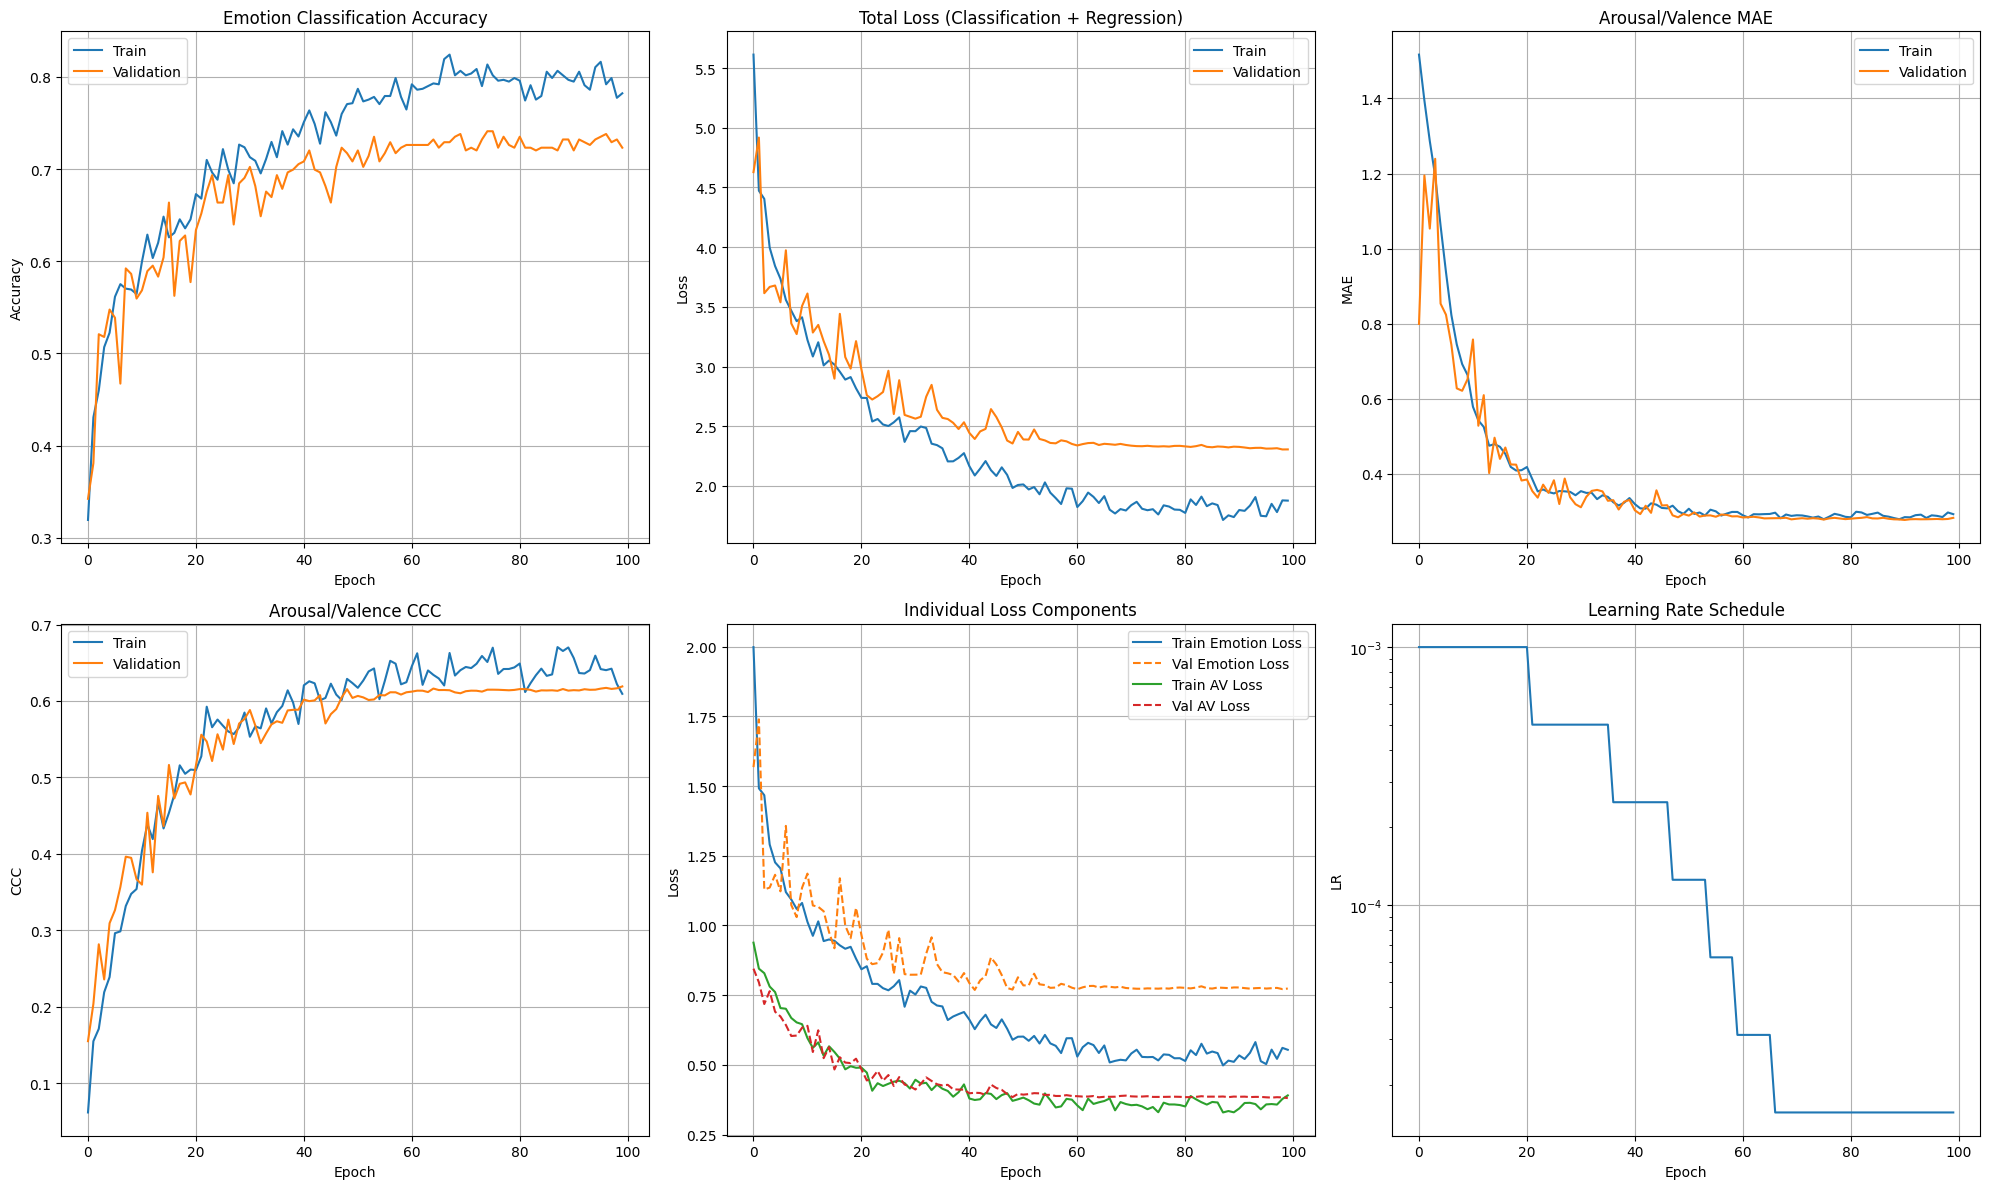


Final Metrics at Epoch 99:
Train Emotion Accuracy: 0.7822
Val Emotion Accuracy: 0.7232
Train AV CCC: 0.6093
Val AV CCC: 0.6190
Train AV MAE: 0.2923
Val AV MAE: 0.2825


In [9]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np


# Visualize training history
plt.figure(figsize=(20, 12))


# 1. Plot Emotion Accuracy
plt.subplot(2, 3, 1)
plt.plot(history.history['emotion_output_accuracy'], label='Train')
plt.plot(history.history['val_emotion_output_accuracy'], label='Validation')
plt.title('Emotion Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# 2. Plot Total Loss
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Total Loss (Classification + Regression)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# 3. Plot Arousal/Valence MAE
plt.subplot(2, 3, 3)
plt.plot(history.history['arousal_valence_output_mae'], label='Train')
plt.plot(history.history['val_arousal_valence_output_mae'], label='Validation')
plt.title('Arousal/Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)


# 4. Plot Arousal/Valence CCC
plt.subplot(2, 3, 4)
plt.plot(history.history['arousal_valence_output_ccc'], label='Train')
plt.plot(history.history['val_arousal_valence_output_ccc'], label='Validation')
plt.title('Arousal/Valence CCC')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.grid(True)


# 5. Plot Individual Loss Components
plt.subplot(2, 3, 5)
plt.plot(history.history['emotion_output_loss'], label='Train Emotion Loss')
plt.plot(history.history['val_emotion_output_loss'], label='Val Emotion Loss', linestyle='--')
plt.plot(history.history['arousal_valence_output_loss'], label='Train AV Loss')
plt.plot(history.history['val_arousal_valence_output_loss'], label='Val AV Loss', linestyle='--')
plt.title('Individual Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# 6. Plot Learning Rate Schedule
if 'lr' in history.history:
    plt.subplot(2, 3, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.yscale('log')
    plt.grid(True)

plt.tight_layout()
plt.show()


# Print final metrics
final_epoch = len(history.history['loss']) - 1
print(f"\nFinal Metrics at Epoch {final_epoch}:")
print(f"Train Emotion Accuracy: {history.history['emotion_output_accuracy'][-1]:.4f}")
print(f"Val Emotion Accuracy: {history.history['val_emotion_output_accuracy'][-1]:.4f}")
print(f"Train AV CCC: {history.history['arousal_valence_output_ccc'][-1]:.4f}")
print(f"Val AV CCC: {history.history['val_arousal_valence_output_ccc'][-1]:.4f}")
print(f"Train AV MAE: {history.history['arousal_valence_output_mae'][-1]:.4f}")
print(f"Val AV MAE: {history.history['val_arousal_valence_output_mae'][-1]:.4f}")